# Global Forecasting Models: Independent multi-series forecasting

[Univariate time series forecasting](https://skforecast.org/latest/introduction-forecasting/introduction-forecasting.html) models a single time series as a linear or nonlinear combination of its lags, using past values of the series to predict its future. Global forecasting, involves building a single predictive model that considers all time series simultaneously. It attempts to capture the core patterns that govern the series, thereby mitigating the potential noise that each series might introduce. This approach is computationally efficient, easy to maintain, and can yield more robust generalizations across time series.

In **independent multi-series forecasting** a single model is trained for all time series, but each time series remains independent of the others, meaning that past values of one series are not used as predictors of other series. However, modeling them together is useful because the series may follow the same intrinsic pattern regarding their past and future values. For instance, the sales of products A and B in the same store may not be related, but they follow the same dynamics, that of the store.

<p style="text-align: center">
<img src="../img/forecaster_multi_series_train_matrix_diagram.png" style="width: 700px">
<br>
<font size="2.5"> <i>Internal Forecaster transformation of two time series and an exogenous variable into the matrices needed to train a machine learning model in a multi-series context.</i></font>
</p>

To predict the next *n* steps, the strategy of [recursive multi-step forecasting](https://skforecast.org/latest/introduction-forecasting/introduction-forecasting.html#recursive-multi-step-forecasting) is applied, with the only difference being that the series name for which to estimate the predictions needs to be indicated.

<p style="text-align: center">
<img src="../img/forecaster_multi_series_prediction_diagram.png" style="width: 700px">
<br>
<font size="2.5"> <i>Diagram of recursive forecasting with multiple independent time series.</i></font>
</p>

Using the `ForecasterAutoregMultiSeries` and `ForecasterAutoregMultiSeriesCustom` classes, it is possible to easily build machine learning models for independent multi-series forecasting.

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

Skforecast offers additional approaches to create Global Forecasting Models:

<ul>
    <li>
    <a href="https://skforecast.org/latest/user_guides/window-features-and-custom-features#forecasterautoregmultiseriescustom">Global Forecasting Models: Independent multi-series forecasting using window and custom features</a>
    </li>
    <li>
    <a href="https://skforecast.org/latest/user_guides/multi-series-with-different-length-and-different_exog">Global Forecasting Models: Time series with different lengths and different exogenous variables</a>
    </li>
    <li>
    <a href="https://skforecast.org/latest/user_guides/dependent-multi-series-multivariate-forecasting.html">Global Forecasting Models: Dependent multi-series forecasting (Multivariate forecasting)</a>
    </li>
</ul>

</div>

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

To learn more about global forecasting models visit our examples:

<ul>
    <li>
    <a href="https://www.cienciadedatos.net/documentos/py44-multi-series-forecasting-skforecast.html">Global Forecasting Models: Multi-series forecasting with Python and skforecast</a>
    </li>
    <li>
    <a href="https://cienciadedatos.net/documentos/py53-global-forecasting-models">Global Forecasting Models: Comparative Analysis of Single and Multi-Series Forecasting Modeling</a>
    </li>
</ul>

</div>

## Libraries

In [1]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

from skforecast.datasets import fetch_dataset
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries

## Data

In [2]:
# Data download
# ==============================================================================
data = fetch_dataset(name="items_sales")
data.head()

items_sales
-----------
Simulated time series for the sales of 3 different items.
Simulated data.
Shape of the dataset: (1097, 3)


,item_1,item_2,item_3
date,,,
2012-01-01,8.253175,21.047727,19.429739
2012-01-02,22.777826,26.578125,28.009863
2012-01-03,27.549099,31.751042,32.078922
2012-01-04,25.895533,24.567708,27.252276
2012-01-05,21.379238,18.191667,20.357737


In [3]:
# Split data into train-val-test
# ==============================================================================
end_train = '2014-07-15 23:59:00'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(
    f"Train dates : {data_train.index.min()} --- {data_train.index.max()}   "
    f"(n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}   "
    f"(n={len(data_test)})"
)

Train dates : 2012-01-01 00:00:00 --- 2014-07-15 00:00:00   (n=927)
Test dates  : 2014-07-16 00:00:00 --- 2015-01-01 00:00:00   (n=170)


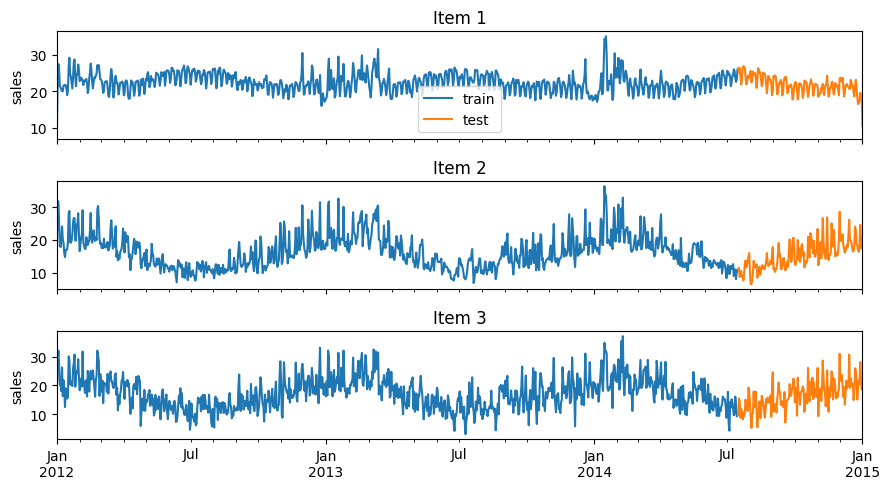

In [4]:
# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 5), sharex=True)

data_train['item_1'].plot(label='train', ax=axes[0])
data_test['item_1'].plot(label='test', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('sales')
axes[0].set_title('Item 1')
axes[0].legend()

data_train['item_2'].plot(label='train', ax=axes[1])
data_test['item_2'].plot(label='test', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('sales')
axes[1].set_title('Item 2')

data_train['item_3'].plot(label='train', ax=axes[2])
data_test['item_3'].plot(label='test', ax=axes[2])
axes[2].set_xlabel('')
axes[2].set_ylabel('sales')
axes[2].set_title('Item 3')

fig.tight_layout()
plt.show();

## Train and predict ForecasterAutoregMultiSeries

In [5]:
# Create and fit a Forecaster Multi-Series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 encoding           = 'ordinal',
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None,
                 differentiation    = None,
                 dropna_from_series = False,
                 fit_kwargs         = None,
                 forecaster_id      = None
             )

forecaster.fit(series=data_train)
forecaster

ForecasterAutoregMultiSeries 
Regressor: LGBMRegressor(random_state=123, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for series: None 
Transformer for exog: None 
Series encoding: ordinal 
Window size: 24 
Series levels (names): ['item_1', 'item_2', 'item_3'] 
Series weights: None 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: ["'item_1': ['2012-01-01', '2014-07-15']", "'item_2': ['2012-01-01', '2014-07-15']", "'item_3': ['2012-01-01', '2014-07-15']"] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: boosting_type: gbdt, class_weight: None, colsample_bytree: 1.0, importance_type: split, learning_rate: 0.1, ... 
fit_kwargs: {} 
Creation date: 2024-07-17 09:18:17 
Last fit date: 2024-07-17 09:18:18 
Skforecast version: 0.13.0 
Python version: 3.12.4 
Forecaster id: 

Two methods can be use to predict the next n steps: `predict()` or `predict_interval()`. The argument `levels` is used to indicate for which series estimate predictions. If `None` all series will be predicted.

In [6]:
# Predict and predict_interval
# ==============================================================================
steps = 24

# Predictions for item_1
predictions_item_1 = forecaster.predict(steps=steps, levels='item_1')
display(predictions_item_1.head(3))

# Interval predictions for item_1 and item_2
predictions_intervals = forecaster.predict_interval(
    steps  = steps,
    levels = ['item_1', 'item_2'],
    n_boot = 200
)
display(predictions_intervals.head(3))

,item_1
2014-07-16,25.906323
2014-07-17,25.807194
2014-07-18,25.127355


,item_1,item_1_lower_bound,item_1_upper_bound,item_2,item_2_lower_bound,item_2_upper_bound
2014-07-16,25.906323,24.753460,27.545243,10.522491,8.740665,12.718655
2014-07-17,25.807194,24.221439,26.801298,10.623789,8.112683,13.123220
2014-07-18,25.127355,23.515433,26.569362,11.299802,8.887296,13.098867


## Backtesting Multi Series

As in the `predict` method, the `levels` at which [backtesting](https://skforecast.org/latest/user_guides/backtesting) is performed must be indicated. The argument can also be set to `None` to perform backtesting at all levels. In addition to the individual metric(s) for each series, the aggregated value is calculated using the following methods:

+ average: the average (arithmetic mean) of all levels.

+ weighted_average: the average of the metrics weighted by the number of predicted values of each level.

+ pooling: the values of all levels are pooled and then the metric is calculated.

In [7]:
# Backtesting Multi-Series
# ==============================================================================
metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
    forecaster            = forecaster,
    series                = data,
    exog                  = None,
    levels                = None,
    steps                 = 24,
    metric                = 'mean_absolute_error',
    add_aggregated_metric = True,
    initial_train_size    = len(data_train),
    fixed_train_size      = True,
    gap                   = 0,
    allow_incomplete_fold = True,
    refit                 = True,
    n_jobs                = 'auto',
    verbose               = False,
    show_progress         = True,
    suppress_warnings     = False
)

print("Backtest metrics")
display(metrics_levels)
print("")
print("Backtest predictions")
backtest_predictions.head(4)

  0%|          | 0/8 [00:00<?, ?it/s]

Backtest metrics


,levels,mean_absolute_error
0,item_1,1.158312
1,item_2,2.563145
2,item_3,3.322265
3,average,2.347908
4,weighted_average,2.347908
5,pooling,2.347908



Backtest predictions


,item_1,item_2,item_3
2014-07-16,25.906323,10.522491,12.034587
2014-07-17,25.807194,10.623789,10.503966
2014-07-18,25.127355,11.299802,12.206434
2014-07-19,23.902609,11.441606,12.618740


## Hyperparameter tuning and lags selection Multi Series

The `grid_search_forecaster_multiseries`, `random_search_forecaster_multiseries` and `bayesian_search_forecaster_multiseries` functions in the `model_selection_multiseries` module allow for lags and hyperparameter optimization. It is performed using the backtesting strategy for validation as in other Forecasters, [see the user guide here](https://skforecast.org/latest/user_guides/hyperparameter-tuning-and-lags-selection), except for the `levels` argument:

`levels`: level(s) at which the forecaster is optimized, for example:

+ If `levels` is a list, the function will search for the lags and hyperparameters that minimize the aggregated error of the predictions of the selected time series. The available aggregation methods are the same as for backtesting (`average`, `weighted_average`, `pooling`). If the `aggregate_metric` argument is a list, all aggregation methods will be calculated for each metric.

+ If `levels = None`, the function will search for the lags and hyperparameters that minimize the aggregated error of the predictions of all time series.

+ If `levels = 'item_1'` (Same as `levels = ['item_1']`), the function will search for the lags and hyperparameters that minimize the error of the `item_1` predictions. The resulting metric will be the one calculated for `item_1`.

The following example shows how to use `grid_search_forecaster_multiseries` to find the best lags and model hyperparameters for all time series (all `levels`).

In [8]:
# Create Forecaster Multi-Series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 encoding           = 'ordinal'
             )

In [9]:
# Grid search Multi-Series
# ==============================================================================
lags_grid = [24, 48]
param_grid = {
    'n_estimators': [10, 20],
    'max_depth': [3, 7]
}

levels = ['item_1', 'item_2', 'item_3']

results = grid_search_forecaster_multiseries(
              forecaster         = forecaster,
              series             = data,
              exog               = None,
              levels             = levels,
              lags_grid          = lags_grid,
              param_grid         = param_grid,
              steps              = 24,
              metric             = 'mean_absolute_error',
              aggregate_metric   = 'weighted_average',
              initial_train_size = len(data_train),
              refit              = False,
              fixed_train_size   = False,
              return_best        = False,
              n_jobs             = 'auto',
              verbose            = False,
              show_progress      = True
          )

results

8 models compared for 3 level(s). Number of iterations: 8.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

,levels,lags,lags_label,params,mean_absolute_error__weighted_average,max_depth,n_estimators
0,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 7, 'n_estimators': 20}",2.240665,7,20
1,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 20}",2.379334,3,20
2,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 7, 'n_estimators': 20}",2.432997,7,20
3,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 20}",2.457422,3,20
4,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 7, 'n_estimators': 10}",3.048544,7,10
5,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 10}",3.245697,3,10
6,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 10}",3.267566,3,10
7,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 7, 'n_estimators': 10}",3.331623,7,10


It is also possible to perform a bayesian optimization with `optuna` using the `bayesian_search_forecaster_multiseries` function. For more information about this type of optimization, see the [user guide here](https://skforecast.org/latest/user_guides/hyperparameter-tuning-and-lags-selection#bayesian-search).

In [10]:
# Bayesian search hyperparameters and lags with Optuna
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 24,
                 encoding  = 'ordinal'
             )

levels = ['item_1', 'item_2', 'item_3']

# Search space
def search_space(trial):
    search_space  = {
        'lags'             : trial.suggest_categorical('lags', [24, 48]),
        'n_estimators'     : trial.suggest_int('n_estimators', 10, 20),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features'     : trial.suggest_categorical('max_features', ['log2', 'sqrt'])
    }

    return search_space

results, best_trial = bayesian_search_forecaster_multiseries(
    forecaster            = forecaster,
    series                = data,
    exog                  = None,
    levels                = levels,
    search_space          = search_space,
    steps                 = 24,
    metric                = 'mean_absolute_error',
    aggregate_metric      = ['weighted_average', 'average', 'pooling'],
    refit                 = False,
    initial_train_size    = len(data_train),
    fixed_train_size      = False,
    n_trials              = 5,
    random_state          = 123,
    return_best           = False,
    n_jobs                = 'auto',
    verbose               = False,
    show_progress         = True,
    suppress_warnings     = False,
    engine                = 'optuna',
    kwargs_create_study   = {},
    kwargs_study_optimize = {}
)

results.head(4)

  0%|          | 0/5 [00:00<?, ?it/s]

,levels,lags,params,mean_absolute_error__weighted_average,n_estimators,min_samples_leaf,max_features
0,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 16, 'min_samples_leaf': 9, 'm...",2.544932,16,9,log2
1,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 15, 'min_samples_leaf': 4, 'm...",2.712388,15,4,sqrt
2,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 14, 'min_samples_leaf': 8, 'm...",2.824843,14,8,log2
3,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 13, 'min_samples_leaf': 3, 'm...",2.984116,13,3,sqrt


`best_trial` contains information of the trial which achived the best results. See more in [Study class](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.Study.html#optuna.study.Study).

In [11]:
# Optuna best trial in the study
# ==============================================================================
best_trial

FrozenTrial(number=3, state=1, values=[2.5449321384350077], datetime_start=datetime.datetime(2024, 7, 17, 9, 18, 32, 92513), datetime_complete=datetime.datetime(2024, 7, 17, 9, 18, 32, 563091), params={'lags': 48, 'n_estimators': 16, 'min_samples_leaf': 9, 'max_features': 'log2'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lags': CategoricalDistribution(choices=(24, 48)), 'n_estimators': IntDistribution(high=20, log=False, low=10, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1), 'max_features': CategoricalDistribution(choices=('log2', 'sqrt'))}, trial_id=3, value=None)

## Exogenous variables in multi-series

Exogenous variables are predictors that are independent of the model being used for forecasting, and their future values must be known in order to include them in the prediction process.

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

Starting from version <code>0.12.0</code>, the `ForecasterAutoregMultiSeries` allows the use of different exogenous variables for each series. See <a href="https://skforecast.org/latest/user_guides/multi-series-with-different-length-and-different_exog.html">Global Forecasting Models: Time series with different lengths and different exogenous variables</a> for more information.
</div>

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

To learn more about exogenous variables in skforecast visit the <a href="https://skforecast.org/latest/user_guides/exogenous-variables">exogenous variables user guide</a>.

</div>

In [12]:
# Generate exogenous variable month
# ==============================================================================
data_exog = data.copy()
data_exog['month'] = data_exog.index.month

# Split data into train-val-test
# ==============================================================================
end_train = '2014-07-15 23:59:00'
data_exog_train = data_exog.loc[:end_train, :].copy()
data_exog_test  = data_exog.loc[end_train:, :].copy()

data_exog_train.head(3)

,item_1,item_2,item_3,month
date,,,,
2012-01-01,8.253175,21.047727,19.429739,1
2012-01-02,22.777826,26.578125,28.009863,1
2012-01-03,27.549099,31.751042,32.078922,1


In [13]:
# Create and fit forecaster Multi-Series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 24,
                 encoding  = 'ordinal'
             )

forecaster.fit(
    series = data_exog_train[['item_1', 'item_2', 'item_3']], 
    exog   = data_exog_train[['month']]
)
forecaster

ForecasterAutoregMultiSeries 
Regressor: LGBMRegressor(random_state=123, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for series: None 
Transformer for exog: None 
Series encoding: ordinal 
Window size: 24 
Series levels (names): ['item_1', 'item_2', 'item_3'] 
Series weights: None 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['month'] 
Training range: ["'item_1': ['2012-01-01', '2014-07-15']", "'item_2': ['2012-01-01', '2014-07-15']", "'item_3': ['2012-01-01', '2014-07-15']"] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: boosting_type: gbdt, class_weight: None, colsample_bytree: 1.0, importance_type: split, learning_rate: 0.1, ... 
fit_kwargs: {} 
Creation date: 2024-07-17 09:18:33 
Last fit date: 2024-07-17 09:18:33 
Skforecast version: 0.13.0 
Py

If the `Forecaster` has been trained using exogenous variables, they should be provided during the prediction phase.

In [14]:
# Predict with exogenous variables
# ==============================================================================
predictions = forecaster.predict(steps=24, exog=data_exog_test[['month']])
predictions.head(3)

,item_1,item_2,item_3
2014-07-16,25.730285,11.557816,11.293334
2014-07-17,25.495978,10.603252,11.438098
2014-07-18,25.238433,11.095160,11.399880


As mentioned earlier, the `month` exogenous variable is replicated for each of the series. This can be easily demonstrated using the `create_train_X_y` method, which returns the matrix used in the `fit` method.

In [15]:
# X_train matrix
# ==============================================================================
X_train = forecaster.create_train_X_y(
    series = data_exog_train[['item_1', 'item_2', 'item_3']], 
    exog   = data_exog_train[['month']]
)[0]

In [16]:
# X_train slice for item_1
# ==============================================================================
X_train.loc[X_train['_level_skforecast'] == 0].head(3)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,_level_skforecast,month
date,,,,,,,,,,,,,,,,,,,,,
2012-01-25,28.018830,23.981037,20.794986,22.503533,24.018768,24.772249,29.245869,26.636444,20.228468,18.976196,...,20.069327,20.533871,21.106643,21.379238,25.895533,27.549099,22.777826,8.253175,0,1
2012-01-26,28.747482,28.018830,23.981037,20.794986,22.503533,24.018768,24.772249,29.245869,26.636444,20.228468,...,20.006161,20.069327,20.533871,21.106643,21.379238,25.895533,27.549099,22.777826,0,1
2012-01-27,23.908368,28.747482,28.018830,23.981037,20.794986,22.503533,24.018768,24.772249,29.245869,26.636444,...,21.620184,20.006161,20.069327,20.533871,21.106643,21.379238,25.895533,27.549099,0,1


In [17]:
# X_train slice for item_2
# ==============================================================================
X_train.loc[X_train['_level_skforecast'] == 1].head(3)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,_level_skforecast,month
date,,,,,,,,,,,,,,,,,,,,,
2012-01-25,26.675000,25.332292,21.690625,19.688542,19.178125,19.265625,28.779167,28.060417,19.255208,17.096875,...,24.098958,19.510417,17.812500,18.191667,24.567708,31.751042,26.578125,21.047727,1,1
2012-01-26,26.611458,26.675000,25.332292,21.690625,19.688542,19.178125,19.265625,28.779167,28.060417,19.255208,...,20.223958,24.098958,19.510417,17.812500,18.191667,24.567708,31.751042,26.578125,1,1
2012-01-27,19.759375,26.611458,26.675000,25.332292,21.690625,19.688542,19.178125,19.265625,28.779167,28.060417,...,19.161458,20.223958,24.098958,19.510417,17.812500,18.191667,24.567708,31.751042,1,1


To use exogenous variables in backtesting or hyperparameter tuning, they must be specified with the `exog` argument.

In [18]:
# Backtesting Multi-Series with exog
# ==============================================================================
metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
    forecaster            = forecaster,
    series                = data_exog[['item_1', 'item_2', 'item_3']],
    exog                  = data_exog[['month']],
    levels                = None,
    steps                 = 24,
    metric                = 'mean_absolute_error',
    add_aggregated_metric = True,
    initial_train_size    = len(data_exog_train),
    fixed_train_size      = True,
    gap                   = 0,
    allow_incomplete_fold = True,
    refit                 = True,
    n_jobs                = 'auto',
    verbose               = False,
    show_progress         = True,
    suppress_warnings     = False
)

print("Backtest metrics")
display(metrics_levels)
print("")
print("Backtest predictions with exogenous variables")
backtest_predictions.head(4)

  0%|          | 0/8 [00:00<?, ?it/s]

Backtest metrics


,levels,mean_absolute_error
0,item_1,1.227286
1,item_2,2.600569
2,item_3,3.250053
3,average,2.359303
4,weighted_average,2.359303
5,pooling,2.359303



Backtest predictions with exogenous variables


,item_1,item_2,item_3
2014-07-16,25.730285,11.557816,11.293334
2014-07-17,25.495978,10.603252,11.438098
2014-07-18,25.238433,11.095160,11.399880
2014-07-19,23.986693,12.170443,12.525807


## Scikit-learn transformers in multi-series

By default, the `ForecasterAutoregMultiSeries` class uses the scikit-learn `StandardScaler` transformer to scale the data. This transformer is applied to all series. However, it is possible to use different transformers for each series or not to apply any transformation at all:

+ If `transformer_series` is a `transformer` the same transformation will be applied to all series. 

+ If `transformer_series` is a `dict` a different transformation can be set for each series. Series not present in the dict will not have any transformation applied to them (check warning message).

Learn more about [using scikit-learn transformers](https://skforecast.org/latest/user_guides/sklearn-transformers-and-pipeline.html) with skforecast.

In [19]:
# Transformers in Multi-Series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 encoding           = 'ordinal',
                 transformer_series = {'item_1': StandardScaler(), 'item_2': StandardScaler()},
                 transformer_exog   = None
             )

forecaster.fit(series=data_train)
forecaster

/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:235: IgnoredArgumentWarning: {'item_3'} not present in `transformer_series`. No transformation is applied to these series. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=IgnoredArgumentWarning)
  warnings.warn(


ForecasterAutoregMultiSeries 
Regressor: LGBMRegressor(random_state=123, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for series: {'item_1': StandardScaler(), 'item_2': StandardScaler()} 
Transformer for exog: None 
Series encoding: ordinal 
Window size: 24 
Series levels (names): ['item_1', 'item_2', 'item_3'] 
Series weights: None 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: ["'item_1': ['2012-01-01', '2014-07-15']", "'item_2': ['2012-01-01', '2014-07-15']", "'item_3': ['2012-01-01', '2014-07-15']"] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: boosting_type: gbdt, class_weight: None, colsample_bytree: 1.0, importance_type: split, learning_rate: 0.1, ... 
fit_kwargs: {} 
Creation date: 2024-07-17 09:18:35 
Last fit date: 2024-07-17 09:18:36 
Skforecast vers

## Series with different lengths and different exogenous variables

Starting from version `0.12.0`, the classes `ForecasterAutoregMultiSeries` and `ForecasterAutoregMultiSeriesCustom` allow the simultaneous modeling of time series of different lengths and using different exogenous variables. Various scenarios are possible:

- If `series` is a `pandas DataFrame` and `exog` is a `pandas Series` or `DataFrame`, each exog is duplicated for each series. `exog` must have the same index as `series` (type, length and frequency).

- If `series` is a `pandas DataFrame` and `exog` is a dict of `pandas Series` or `DataFrames`. Each key in `exog` must be a column in `series` and the values are the exog for each series. `exog` must have the same index as `series` (type, length and frequency).

- If `series` is a `dict` of `pandas Series`, `exog` must be a dict of `pandas Series` or `DataFrames`. The keys in `series` and `exog` must be the same. All series and exog must have a `pandas DatetimeIndex` with the same frequency.


| Series type  | Exog type               | Requirements                                 |
|:------------:|:-----------------------:|:--------------------------------------------:|
| `DataFrame`  | `Series` or `DataFrame` | Same index (type, length and frequency)      |
| `DataFrame`  | `dict`                  | Same index (type, length and frequency)      |
| `dict`       | `dict`                  | Both `pandas DatetimeIndex` (same frequency) |

In [20]:
# Series and exog as DataFrames 
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 4,
                 encoding           = 'ordinal',
                 transformer_series = StandardScaler()
             )

X, y = forecaster.create_train_X_y(
    series = data_exog_train[['item_1', 'item_2', 'item_3']], 
    exog   = data_exog_train[['month']]
)
X.head(3)

,lag_1,lag_2,lag_3,lag_4,_level_skforecast,month
date,,,,,,
2012-01-05,1.334476,1.979794,0.117764,-5.550607,0,1
2012-01-06,-0.428047,1.334476,1.979794,0.117764,0,1
2012-01-07,-0.534430,-0.428047,1.334476,1.979794,0,1


When `exog` is a dictionary of `pandas Series` or `DataFrames`, different exogenous variables can be used for each series or the same exogenous variable can have different values for each series.

In [21]:
# Ilustrative example of different values for the same exogenous variable
# ==============================================================================
exog_1_item_1_train = pd.Series([1]*len(data_exog_train), name='exog_1', index=data_exog_train.index)
exog_1_item_2_train = pd.Series([10]*len(data_exog_train), name='exog_1', index=data_exog_train.index)
exog_1_item_3_train = pd.Series([100]*len(data_exog_train), name='exog_1', index=data_exog_train.index)

exog_1_item_1_test = pd.Series([1]*len(data_exog_test), name='exog_1', index=data_exog_test.index)
exog_1_item_2_test = pd.Series([10]*len(data_exog_test), name='exog_1', index=data_exog_test.index)
exog_1_item_3_test = pd.Series([100]*len(data_exog_test), name='exog_1', index=data_exog_test.index)

In [22]:
# Series as DataFrame and exog as dict
# ==============================================================================
exog_train_as_dict = {
    'item_1': exog_1_item_1_train,
    'item_2': exog_1_item_2_train,
    'item_3': exog_1_item_3_train
}

forecaster = ForecasterAutoregMultiSeries(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 4,
                 encoding  = 'ordinal'
             )

X, y = forecaster.create_train_X_y(
    series = data_exog_train[['item_1', 'item_2', 'item_3']], 
    exog   = exog_train_as_dict
)

display(X.head(3))
print("")
print("Column `exog_1` as different values for each item (_level_skforecast id)")
X['exog_1'].value_counts()

,lag_1,lag_2,lag_3,lag_4,_level_skforecast,exog_1
date,,,,,,
2012-01-05,25.895533,27.549099,22.777826,8.253175,0,1
2012-01-06,21.379238,25.895533,27.549099,22.777826,0,1
2012-01-07,21.106643,21.379238,25.895533,27.549099,0,1



Column `exog_1` as different values for each item (_level_skforecast id)


exog_1
1      923
10     923
100    923
Name: count, dtype: int64

In [23]:
# Predict with series as DataFrame and exog as dict
# ==============================================================================
forecaster.fit(
    series = data_exog_train[['item_1', 'item_2', 'item_3']], 
    exog   = exog_train_as_dict
)

exog_pred_as_dict = {
    'item_1': exog_1_item_1_test,
    'item_2': exog_1_item_2_test,
    'item_3': exog_1_item_3_test
}

predictions = forecaster.predict(steps=24, exog=exog_pred_as_dict)
predictions.head(3)

,item_1,item_2,item_3
2014-07-16,25.648910,10.677388,12.402632
2014-07-17,25.370120,11.401488,11.974233
2014-07-18,25.168771,12.805684,11.657917


<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

When using series with different lengths and different exogenous variables, it is recommended to use <code>series</code> and <code>exog</code> as dictionaries. This way, it is easier to manage the data and avoid errors.

Visit <a href="https://skforecast.org/latest/user_guides/multi-series-with-different-length-and-different_exog.html">Global Forecasting Models: Time series with different lengths and different exogenous variables</a> for more information.

</div>

## Series Encoding in multi-series

When creating the training matrices, the `ForecasterAutoregMultiSeries` class encodes the series names to identify to which series the observations belong. Different encoding methods can be used:

- `'ordinal_category'` (default): a single column (`_level_skforecast`) is created with integer values from 0 to n_series - 1. Then, the column is transformed into `pandas.category` dtype so that it can be used as a categorical variable.

- `'ordinal'`: a single column (`_level_skforecast`) is created with integer values from 0 to n_series - 1.

- `'onehot'`, a binary column is created for each series.

In [24]:
# Ordinal_category encoding
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 3,
                 encoding  = 'ordinal_category'
             )

X, y = forecaster.create_train_X_y(series=data_train)

display(X.head(3))
print("")
print(X.dtypes)
print("")
print(X['_level_skforecast'].value_counts())

,lag_1,lag_2,lag_3,_level_skforecast
date,,,,
2012-01-04,27.549099,22.777826,8.253175,0
2012-01-05,25.895533,27.549099,22.777826,0
2012-01-06,21.379238,25.895533,27.549099,0



lag_1                 float64
lag_2                 float64
lag_3                 float64
_level_skforecast    category
dtype: object

_level_skforecast
0    924
1    924
2    924
Name: count, dtype: int64


In [25]:
# Ordinal encoding
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 3,
                 encoding  = 'ordinal'
             )

X, y = forecaster.create_train_X_y(series=data_train)

display(X.head(3))
print("")
print(X.dtypes)
print("")
print(X['_level_skforecast'].value_counts())

,lag_1,lag_2,lag_3,_level_skforecast
date,,,,
2012-01-04,27.549099,22.777826,8.253175,0
2012-01-05,25.895533,27.549099,22.777826,0
2012-01-06,21.379238,25.895533,27.549099,0



lag_1                float64
lag_2                float64
lag_3                float64
_level_skforecast      int64
dtype: object

_level_skforecast
0    924
1    924
2    924
Name: count, dtype: int64


In [26]:
# Onehot encoding (one column per series)
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 3,
                 encoding  = 'onehot'
             )

X, y = forecaster.create_train_X_y(series=data_train)

display(X.head(3))
print("")
print(X.dtypes)
print("")
print(X['item_1'].value_counts())

,lag_1,lag_2,lag_3,item_1,item_2,item_3
date,,,,,,
2012-01-04,27.549099,22.777826,8.253175,1,0,0
2012-01-05,25.895533,27.549099,22.777826,1,0,0
2012-01-06,21.379238,25.895533,27.549099,1,0,0



lag_1     float64
lag_2     float64
lag_3     float64
item_1      int64
item_2      int64
item_3      int64
dtype: object

item_1
0    1848
1     924
Name: count, dtype: int64


## Weights in multi-series

The weights are used to control the influence that each observation has on the training of the model. `ForecasterAutoregMultiseries` accepts two types of weights:

+ `series_weights` controls the relative importance of each series. If a series has twice as much weight as the others, the observations of that series influence the training twice as much. The higher the weight of a series relative to the others, the more the model will focus on trying to learn that series.

+ `weight_func` controls the relative importance of each observation according to its index value. For example, a function that assigns a lower weight to certain dates.

If the two types of weights are indicated, they are **multiplied to create the final weights**. The resulting `sample_weight` cannot have negative values.

<p style="text-align: center">
<img src="../img/forecaster_multi_series_sample_weight.png" style="width: 900px">
<br>
<font size="2.5"> <i>Weights in multi-series.</i></font>
</p>

+ `series_weights` is a dict of the form `{'series_column_name': float}`. If a series is used during `fit` and is not present in `series_weights`, it will have a weight of 1.

+ `weight_func` is a function that defines the individual weights of each sample **based on the index**. 
  
    + If it is a `callable`, the same function will apply to all series. 
  
    + If it is a `dict` of the form `{'series_column_name': callable}`, a different function can be used for each series. A weight of 1 is given to all series not present in `weight_func`.

In [27]:
# Weights in Multi-Series
# ==============================================================================
def custom_weights(index):
    """
    Return 0 if index is between '2013-01-01' and '2013-01-31', 1 otherwise.
    """
    weights = np.where(
                  (index >= '2013-01-01') & (index <= '2013-01-31'),
                   0,
                   1
              )
    
    return weights

forecaster = ForecasterAutoregMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 encoding           = 'ordinal',
                 transformer_series = StandardScaler(),
                 transformer_exog   = None,
                 weight_func        = custom_weights,
                 series_weights     = {'item_1': 1., 'item_2': 2., 'item_3': 1.} # Same as {'item_2': 2.}
             )

forecaster.fit(series=data_train)
forecaster.predict(steps=24).head(3)

,item_1,item_2,item_3
2014-07-16,26.073036,10.891763,12.142271
2014-07-17,26.457289,10.728702,10.170189
2014-07-18,25.811176,10.730621,12.808785


<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

The <code>weight_func</code> and <code>series_weights</code> arguments will be ignored if the regressor does not accept <code>sample_weight</code> in its <code>fit</code> method.

</div>

The source code of the `weight_func` added to the forecaster is stored in the argument `source_code_weight_func`. If `weight_func` is a `dict`, it will be a `dict` of the form `{'series_column_name': source_code_weight_func}` .

In [28]:
# Source code weight function
# ==============================================================================
print(forecaster.source_code_weight_func)

def custom_weights(index):
    """
    Return 0 if index is between '2013-01-01' and '2013-01-31', 1 otherwise.
    """
    weights = np.where(
                  (index >= '2013-01-01') & (index <= '2013-01-31'),
                   0,
                   1
              )
    
    return weights



## Differentiation

Time series differentiation involves computing the differences between consecutive observations in the time series. When it comes to training forecasting models, differentiation offers the advantage of focusing on relative rates of change rather than directly attempting to model the absolute values. Once the predictions have been estimated, this transformation can be easily reversed to restore the values to their original scale.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

To learn more about modeling time series differentiation, visit our example: <a href="https://www.cienciadedatos.net/documentos/py49-modelling-time-series-trend-with-tree-based-models.html">Modelling time series trend with tree based models</a>.

</div>

In [29]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor       = LGBMRegressor(random_state=123, verbose=-1),
                 lags            = 24,
                 differentiation = 1
             )

forecaster.fit(series=data_train)
forecaster

ForecasterAutoregMultiSeries 
Regressor: LGBMRegressor(random_state=123, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for series: None 
Transformer for exog: None 
Series encoding: ordinal_category 
Window size: 24 
Series levels (names): ['item_1', 'item_2', 'item_3'] 
Series weights: None 
Weight function included: False 
Differentiation order: 1 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: ["'item_1': ['2012-01-01', '2014-07-15']", "'item_2': ['2012-01-01', '2014-07-15']", "'item_3': ['2012-01-01', '2014-07-15']"] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: boosting_type: gbdt, class_weight: None, colsample_bytree: 1.0, importance_type: split, learning_rate: 0.1, ... 
fit_kwargs: {} 
Creation date: 2024-07-17 09:18:37 
Last fit date: 2024-07-17 09:18:38 
Skforecast version: 0.13.0 
Python version: 3.12.4 
Forecaste

In [30]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=24)
predictions.head(3)

,item_1,item_2,item_3
2014-07-16,26.415599,9.382244,9.197428
2014-07-17,26.542300,9.863923,8.721811
2014-07-18,26.638615,10.387266,11.806588


## Feature selection in multi-series

Feature selection is the process of selecting a subset of relevant features (variables, predictors) for use in model construction. Feature selection techniques are used for several reasons: to simplify models to make them easier to interpret, to reduce training time, to avoid the curse of dimensionality, to improve generalization by reducing overfitting (formally, variance reduction), and others.

Skforecast is compatible with the [feature selection methods implemented in the scikit-learn](https://scikit-learn.org/stable/modules/feature_selection.html) library. Visit [Global Forecasting Models: Feature Selection](https://skforecast.org/latest/user_guides/feature-selection#global-forecasting-models-feature-selection) for more information.

## Compare multiple metrics

All four functions (`backtesting_forecaster_multiseries`, `grid_search_forecaster_multiseries`,  `random_search_forecaster_multiseries`, and `bayesian_search_forecaster_multiseries`) allow the calculation of multiple metrics, including custom metrics, for each forecaster configuration if a list is provided.

The best model is selected based on the **first metric** in the list and the **first aggregation method** (if more than one is indicated).

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

To learn more about metrics, visit our user guide: <a href="https://skforecast.org/latest/user_guides/metrics.html">Time Series Forecasting Metrics</a>.

</div>

In [31]:
# Grid search Multi-Series with multiple metrics
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 24,
                 encoding  = 'ordinal'
             )

def custom_metric(y_true, y_pred):
    """
    Calculate the mean absolute error using only the predicted values of the last
    3 months of the year.
    """
    mask = y_true.index.month.isin([10, 11, 12])
    metric = mean_absolute_error(y_true[mask], y_pred[mask])
    
    return metric

lags_grid = [24, 48]
param_grid = {
    'n_estimators': [10, 20],
    'max_depth': [3, 7]
}

results = grid_search_forecaster_multiseries(
              forecaster         = forecaster,
              series             = data,
              lags_grid          = lags_grid,
              param_grid         = param_grid,
              steps              = 24,
              metric             = [mean_absolute_error, custom_metric, 'mean_squared_error'],
              aggregate_metric   = ['weighted_average', 'average', 'pooling'],
              initial_train_size = len(data_train),
              fixed_train_size   = True,
              levels             = None,
              exog               = None,
              refit              = True,
              return_best        = False,
              n_jobs             = 'auto',
              verbose            = False,
              show_progress      = True
          )

results

8 models compared for 3 level(s). Number of iterations: 8.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

,levels,lags,lags_label,params,mean_absolute_error__weighted_average,custom_metric__weighted_average,mean_squared_error__weighted_average,max_depth,n_estimators
0,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 7, 'n_estimators': 20}",2.288448,2.314922,9.462712,7,20
1,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 7, 'n_estimators': 20}",2.357734,2.306112,10.121310,7,20
2,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 20}",2.377537,2.302790,10.179578,3,20
3,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 20}",2.474797,2.365732,10.708651,3,20
4,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 7, 'n_estimators': 10}",3.088904,2.642092,14.761587,7,10
5,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 7, 'n_estimators': 10}",3.134955,2.565650,15.509249,7,10
6,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 10}",3.208173,2.600285,15.870433,3,10
7,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 10}",3.240515,2.638598,16.016639,3,10


## Extract training matrices

To examine how data is being transformed, it is possible to use the `create_train_X_y` method to generate the matrices that the forecaster is using to train the model. This approach enables gaining insight into the specific data manipulations that occur during the training process.

In [32]:
# Create and fit a Forecaster Multi-Series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 3,
                 encoding           = 'ordinal',
                 dropna_from_series = False,
             )

In [33]:
# Create training matrices
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(data_train)
X_train.head()

,lag_1,lag_2,lag_3,_level_skforecast
date,,,,
2012-01-04,27.549099,22.777826,8.253175,0
2012-01-05,25.895533,27.549099,22.777826,0
2012-01-06,21.379238,25.895533,27.549099,0
2012-01-07,21.106643,21.379238,25.895533,0
2012-01-08,20.533871,21.106643,21.379238,0


In [34]:
y_train.head()

date
2012-01-04    25.895533
2012-01-05    21.379238
2012-01-06    21.106643
2012-01-07    20.533871
2012-01-08    20.069327
Name: y, dtype: float64

## Extract prediction matrices

Skforecast provides the `create_predict_X` method to generate the matrices that the forecaster is using to make predictions. This method can be used to gain insight into the specific data manipulations that occur during the prediction process.

In [35]:
# Fit the forecaster
# ==============================================================================
forecaster.fit(series=data_train)

In [36]:
# Create input matrix for predict method
# ==============================================================================
X_predict_dict = forecaster.create_predict_X(steps=5)

# Check 'item_1' matrix
X_predict = X_predict_dict['item_1']
X_predict.head()

,lag_1,lag_2,lag_3,_level_skforecast
2014-07-16,25.980745,23.307307,22.609388,0.0
2014-07-17,25.778936,25.980745,23.307307,0.0
2014-07-18,24.965677,25.778936,25.980745,0.0
2014-07-19,23.929113,24.965677,25.778936,0.0
2014-07-20,23.458191,23.929113,24.965677,0.0
